# Описание проекта <a class="anchor" id="2"></a>

Наше задание: помочь маркетологам оптимизировать маркетинговые затраты.

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Выручка измеряется в условных единицах — у.е.


Для анализа нам уже предоставили описание данных датасетов:

Таблица ```visits``` (лог сервера с информацией о посещениях сайта):
* *Uid* — уникальный идентификатор пользователя
* *Device* — категория устройства пользователя
* *Start Ts* — дата и время начала сессии
* *End Ts* — дата и время окончания сессии
* *Source Id* — идентификатор рекламного источника, из которого пришел пользователь

Таблица ```orders``` (информация о заказах):
* *Uid* — уникальный id пользователя, который сделал заказ
* *Buy Ts* — дата и время заказа
* *Revenue* — выручка Яндекс.Афиши с этого заказа

Таблица ```costs``` (информация о затратах на маркетинг):
* *source_id* — идентификатор рекламного источника
* *dt* — дата
* *costs* — затраты на этот рекламный источник в этот день

Мы изучим:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент,
* когда клиент окупается.

Нам предстоит подготовить данные, чтобы исследовать продукт и проанализировать продажи и маркетинг. На основе полученных данных мы сформулируем рекомендации куда и сколько вкладывать денег маркетологам. Выберем прибыльные источники/платформы на основе полученных метрик.

<a class="anchor" id="1"></a>
### Разделы исследования данных

* [Загружаем данные и подготавливаем их к анализу](#chapter1)

* [Строим отчёты и считаем метрики](#chapter2)

    * [Исследуем продукт](#section_2_1)
     * [Считаем DAU, WAU и MAU](#section_2_1_1)
     * [Определяем регулярность сессий в день](#section_2_1_2)
     * [Длительность одной сессии](#section_2_1_3)
     * [Считаем `Retention Rate`, применяя когортный анализ](#section_2_1_4)

    * [Анализируем продажи](#section_2_2)
     * [Среднее время от первого посещения сайта до покупки](#section_2_2_1)
     * [Считаем среднее количество покупок на одного клиента за 6 месяцев, применяя когортный анализ](#section_2_2_2)
     * [Средний чек пользователя](#section_2_2_3)
     * [Выясняем, как меняется во времени накопительный LTV по когортам. Сравниваем средний LTV по когортам за 6 месяцев](#section_2_2_4)    
    * [Маркетинг](#section_2_3)
     * [Выясняем, как траты распределены по источникам и как меняется это распределение во времени](#section_2_3_1)
     * [Рассчитываем стоимость привлечение одного покупателя из каждого источника трафика](#section_2_3_2)
     * [ROMI по когортам в разрезе источников](#section_2_3_3)
    
* [Рекомендации](#chapter3)
    * [Источники трафика и тип устройств, на которые маркетологам стоит делать упор](#section_3_1)
    * [Самые перспективные для компании когорты клиентов](#section_3_2)
    * [Различие метрик в разрезе устройств](#section_3_3)

<a class="anchor" id="chapter1"></a> 
### Загружаем данные и подготавливаем их к анализу 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import datetime
import plotly.express as px

Загрузим каждый датасет и поочередно посмотрим на формат предоставленных данных, а также проверим их на наличие пропущенных значений и дубликатов.

In [2]:
# Открываем первый датасет с визитами и сохраняем его в переменную visits
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
# Открываем второй датасет с заказами и сохраняем его в переменную orders
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
# Открываем третий датасет с расходами и сохраняем его в переменную costs
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
# Выведем на экран первые 10 строк таблицы visits
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [6]:
#Изучим информацию о самой таблице с данными visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Переименуем столбцы таблицы так, что бы все названия были только в нижнем регистре, а пробелы заменим на - "**__**".

In [7]:
# Используем метод "str.lower()" для применения нижнего регистра ко всем колонкам
visits.columns = visits.columns.str.lower()
visits.sample()

,device,end ts,source id,start ts,uid
243175,desktop,2018-02-21 16:13:00,5,2018-02-21 16:08:00,17235304173545048304


In [8]:
#Переименовываем колонки датасета избавляясь от знака "пробел", используем метод "rename", новые имена присваиваем через ключи
visits.rename(columns={'end ts': 'end_ts', \
                       'source id': 'source_id', \
                       'start ts': 'start_ts'}, inplace=True)

In [9]:
#Выведем на экран случайную выборку
visits.sample()

,device,end_ts,source_id,start_ts,uid
188091,desktop,2017-11-24 17:52:00,2,2017-11-24 16:48:00,8269303080660865199


Как мы видим из <a class="anchor" href="#2">описания</a>, в колонках `end ts` и `start ts` содержится информация о дате и времени начала/окончании сессии, следовательно мы изменим формат на *datetime*.

Индентификатор рекламного источника `source id` - целочисленное значение, но можно понизить разрядность. Cделать то же самое с колонкой `uid` мы не можем, потому что она уже в формате *uint* - беззнаковое длинное число и отвечает за уникальное значение пользователя.

А тип используемого девайса переведем в категорию *category*.

In [10]:
#Изменяем формат колонки "end_ts" на формат "datetime"
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [11]:
#Изменяем формат колонки "start_ts" на формат "datetime"
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [12]:
#Понижаем разрядность целочисленных значений в колонке "source_id" с помощью библиотеки numpy
visits['source_id'] = pd.to_numeric(visits['source_id'], downcast='signed')

In [13]:
#Меняем формат колонки "device" на формат "category"
visits['device'] = visits['device'].astype('category')

In [14]:
# Выведем на экран первые 5 строк таблицы visits
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [15]:
#Просмотрим информацию о самой таблице с данными visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null category
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int8
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int8(1), uint64(1)
memory usage: 8.9 MB


Мы обработали все колонки датасета *visits*, изменили тип данных и сэкономили около 5Мб памяти.
Просмотрим информацию о пропусках и дубликатах, а также выясним через какие девайсы и рекламные источники была пользовательская сессия.

In [16]:
#Просмотрим количество пропусков в процентном выражении таблицы visits
visits.isna().mean()

device       0.0
end_ts       0.0
source_id    0.0
start_ts     0.0
uid          0.0
dtype: float64

In [17]:
#Определим количество дубликатов в таблице visits
visits.duplicated().value_counts()

False    359400
dtype: int64

In [18]:
# Группируем источники по используемым девайсам
visits.groupby('device')['source_id'].value_counts()

device   source_id
desktop  4            67640
         3            65777
         5            50069
         2            35661
         1            25901
         9            10119
         10            7367
         7               28
         6                5
touch    4            34154
         3            19833
         5            16836
         2            11965
         1             8220
         9             3158
         10            2658
         7                8
         6                1
Name: source_id, dtype: int64

In [19]:
#Выводим на экран список уникальных значений столбца "source_id"
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [20]:
#Выводим на экран список уникальных значений столбца "device"
visits['device'].unique()

[touch, desktop]
Categories (2, object): [touch, desktop]

In [21]:
#Выводим на экран список уникальных значений столбца "uid"
len(visits['uid'].unique())

228169

На первый взгляд, *desktop* версия используется чаще, чем *touch*. Рекламные источники **6** и **7** самые специфичные - по ним очень мало переходов. Всего рекламных источников - девять.
Уникальных пользователей - 228169, значит у некоторых из них зафиксировано несколько сессий.

In [22]:
#Ищем число строк с сессиями, где время начало сессии больше ее окончания
(visits['start_ts'] > visits['end_ts']).value_counts()

False    359398
True          2
dtype: int64

In [23]:
#Ищем число строк с сессиями, где время начало сессии равно времени ее окончания
(visits['start_ts'] == visits['end_ts']).value_counts()

False    323606
True      35794
dtype: int64

In [24]:
#Выводим на экран первые пять строк удовлетворяющих условию время начала сессии равно времени окончания сессии
visits[visits['start_ts'] == visits['end_ts']].head()

,device,end_ts,source_id,start_ts,uid
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332


Как мы видим, данные, где время начала сессии больше, чем время ее окончания, отсутствуют. Но, в этих данных присутствуют сессии, где продолжительность сессии равна 0. Скорее всего, это происходит из-за того, что время сессий фиксируется без  секунд.

Перейдем ко второй таблице с заказами *orders*.

In [25]:
# Выведем на экран первые 10 строк таблицы orders
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [26]:
#Изучим информацию о самой таблице с данными orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Переименуем столбцы таблицы так, что бы все названия были только в нижнем регистре, а пробелы заменим на - "**__**".

In [27]:
# Используем метод "str.lower()" для применения нижнего регистра ко всем колонкам
orders.columns = orders.columns.str.lower()
orders.sample()

,buy ts,revenue,uid
10015,2017-10-01 21:51:00,1.1,12727930046312831424


In [28]:
#Переименовываем колонки датасета избавляясь от знака "пробел", используем метод "rename", новые имена присваиваем через ключи
orders.rename(columns={'buy ts': 'buy_ts'}, inplace=True)

In [29]:
#Выведем на экран случайную выборку
orders.sample()

,buy_ts,revenue,uid
38270,2018-03-05 12:06:00,18.67,6321595941486066911


Из <a class="anchor" href="#2">описания</a>, в колонке `buy ts` содержится информация о дате и времени заказа, следовательно мы изменим формат на *datetime*.

Столбец с id пользователей `uid` мы оставим как есть, потому что `uid` уже в формате *uint* - беззнаковое длинное число и отвечает за уникальное значение пользователя.

Округление колонки `revenue` приведет к некорректному отображению выручки компании, здесь мы только понижаем разрядность.

In [30]:
#Изменяем формат колонки "buy_ts" на формат "datetime"
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [31]:
#Понижаем разрядность целочисленных значений в колонке "revenue" с помощью библиотеки numpy
orders['revenue'] = pd.to_numeric(orders['revenue'], downcast='float')

In [32]:
#Выводим на экран информацию о таблице с данными orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float32
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.8 KB


In [33]:
#Выведем на экран случайную выборку
orders.sample()

,buy_ts,revenue,uid
19111,2017-11-24 09:19:00,2.33,2957429882320307670


Мы переименовали столбцы в `orders`, сэкономили место в памяти, переведя данные в удобный для нас формат для анализа.

In [34]:
#Просмотрим количество пропусков в процентном выражении таблицы orders
orders.isna().mean()

buy_ts     0.0
revenue    0.0
uid        0.0
dtype: float64

In [35]:
#Определим количество дубликатов в таблице orders
orders.duplicated().value_counts()

False    50415
dtype: int64

In [36]:
#Проверяем выручку на отрицательные значения 
(orders['revenue'] < 0).value_counts()

False    50415
Name: revenue, dtype: int64

In [37]:
#Проверяем выручку на нулевые значения
(orders['revenue'] == 0).value_counts()

False    50364
True        51
Name: revenue, dtype: int64

Дубликаты и пропущенные значения в `orders` отсутствуют.

Есть записи с нулевой суммой покупки. Вероятно, этим пользователям что-то предоставлялось по купону/скидке/промо или же эти пользователи расплачивались покупкой за баллы. 

In [38]:
#Выводим на экран список уникальных значений столбца "uid"
len(orders['uid'].unique())

36523

Количество уникальных пользователей, совершивших покупку отличается от количества пользователей в таблице с визитами - не все пользователи доходят до этапа совершения покупки.

Просмотрим информацию о нашем третьем датасете с расходами - `costs`.

In [39]:
# Выведем на экран первые 10 строк таблицы costs
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [40]:
#Просмотрим информацию о самой таблице с данными costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [41]:
#Просмотрим количество пропусков в процентном выражении таблицы costs
costs.isna().mean()

source_id    0.0
dt           0.0
costs        0.0
dtype: float64

In [42]:
#Определим количество дубликатов в таблице costs
costs.duplicated().value_counts()

False    2542
dtype: int64

Название колонок в удобном для нас формате.
Из <a class="anchor" href="#2">описания</a>, в колонке `dt` отображена дата расхода, следовательно мы изменим формат на *datetime*.

В столбцах `source_id` и `costs` мы понизим разрядность.

In [43]:
#Изменяем формат колонки "dt" на формат "datetime"
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [44]:
#Понижаем разрядность целочисленных значений в колонке "costs" с помощью библиотеки numpy
costs['costs'] = pd.to_numeric(costs['costs'], downcast='float')

In [45]:
#Понижаем разрядность целочисленных значений в колонке "source_id" с помощью библиотеки numpy
costs['source_id'] = pd.to_numeric(costs['source_id'], downcast='signed')

In [46]:
#Выведем на экран случайную выборку
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.199997
1,1,2017-06-02,62.250000
2,1,2017-06-03,36.529999
3,1,2017-06-04,55.000000
4,1,2017-06-05,57.080002


In [47]:
#Просмотрим информацию о самой таблице с данными costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int8
dt           2542 non-null datetime64[ns]
costs        2542 non-null float32
dtypes: datetime64[ns](1), float32(1), int8(1)
memory usage: 32.4 KB


In [48]:
#Проверяем значение столбца на отрицательные и нулевые значения
(costs['costs'] <= 0).value_counts()

False    2542
Name: costs, dtype: int64

В столбце с расходами `costs` отсутствуют отрицательные и нулевые значения.

Мы загрузили и обработали три датасета. Проверили значения на логические ошибки. Изменили тип данных там, где было необходимо, для дальнейших отчетов и подсчета метрик.

<a class="anchor" id="chapter2"></a>
### Строим отчёты и считаем метрики
<a class="anchor" href="#1">Вернуться к оглавлению</a>

В этом разделе мы посчитаем метрики трёх видов:
* продуктовые,
* метрики продаж,
* маркетинговые

<a class="anchor" id="section_2_1"></a>
#### Исследуем продукт
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Для анализа продуктовых метрик нам нужно посчитать сколько людей пользуются продуктом в день - DAU, неделю - WAU, месяц - MAU.  Также, мы посчитаем средние значения этих метрик. Мы определим сколько в среднем за день пользователи заходят на сайт и как изменяется эта метрика во времени.

Мы посчитаем сколько длится одна сессия и определим как часто люди возвращаются на сайт.

<a class="anchor" id="section_2_1_1"></a>
##### Считаем DAU, WAU и MAU 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Для ответа на вопрос "Сколько людей пользуются в день, неделю, месяц?" мы приведем расчет метрик:
* **DAU** (Daily Active Users) — количество уникальных пользователей в день;
* **WAU** (Weekly Active Users) — количество уникальных пользователей в неделю;
* **MAU** (Monthly Active Users) — количество уникальных пользователей в месяц.

Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы в таблице с визитами `visits` "день", "неделя" и "месяц", а также полную дату.

In [49]:
#Добавляем колонки со значениями дня, недели, месяца в таблицу "visits"
visits['session_year']  = visits['start_ts'].dt.year
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month']  = visits['start_ts'].dt.month
visits['session_date'] = visits['start_ts'].dt.date

In [50]:
#Меняем формат столбца "session_date" на "datetime"
visits['session_date'] = pd.to_datetime(visits['session_date'], format='%Y-%m-%d')

In [51]:
#Выводим на экран первые 5 строк таблицы "visits"
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_week,session_month,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,51,12,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,8,2,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,26,7,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,20,5,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,52,12,2017-12-27


Рассчитаем метрики, сгруппировав данные по уникальным пользователям и найдём среднее. Начнем с количества уникальных пользователей в день - **DAU**

In [52]:
#Считаем среднее количество уникальных пользователей в день
dau = visits.groupby('session_date')\
            .agg({'uid': 'nunique'})\
            .mean()
int(dau)

907

In [53]:
#Считаем среднее количество уникальных пользователей на "touch" в день
dau_touch = visits.query('device == "touch"')\
                .groupby('session_date')\
                .agg({'uid': 'nunique'})\
                .mean()
int(dau_touch)

252

In [54]:
#Считаем среднее количество уникальных пользователей на "desktop" в день
dau_desktop = visits.query('device == "desktop"')\
                    .groupby('session_date')\
                    .agg({'uid': 'nunique'})\
                    .mean()
int(dau_desktop)

659

В день наша метрика **DAU** показала, что всего уникальных пользователей в день **907**.


**DAU** для пользователей на *touch* составила - **252**, а для *desktop* - **659**

Text(0.5, 0, 'Дата')

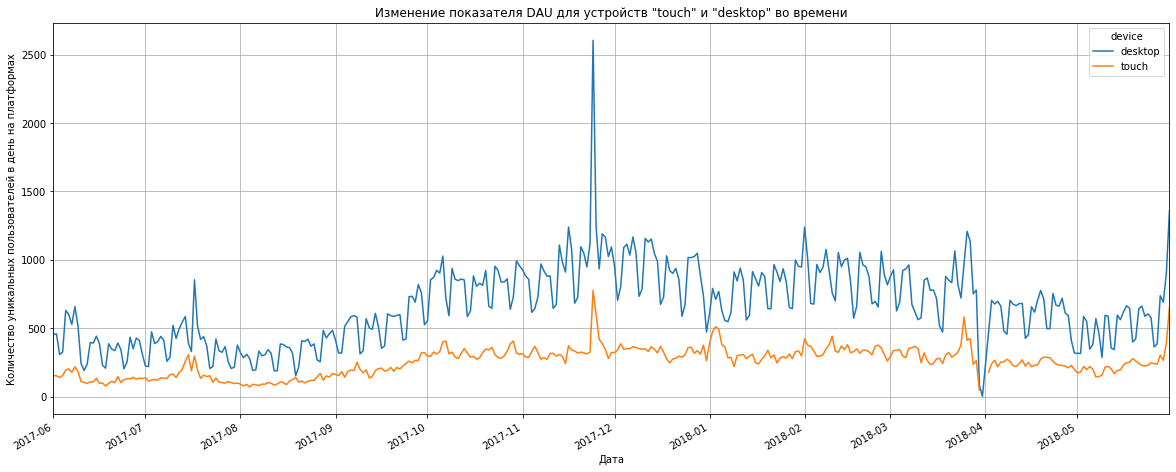

In [55]:
#Строим график по сводной таблице числа уникальных пользователей в день в разрезе устройств
ax = visits.pivot_table(index='session_date', columns='device', values='uid', aggfunc='nunique')\
           .plot(grid=True, figsize=(20, 8), title = 'Изменение показателя DAU для устройств "touch" и "desktop" во времени')
#Подписываем оси
ax.set_ylabel('Количество уникальных пользователей в день на платформах')
ax.set_xlabel('Дата')

In [56]:
#Смотрим описание данных группировки количества уникальных "uid" по каждому дню, для наглядности транспонируем полученные данные
visits.groupby('session_date').agg({'uid': 'nunique'}).sort_values(by = 'uid').describe().T

,count,mean,std,min,25%,50%,75%,max
uid,364.0,907.991758,370.513838,1.0,594.0,921.0,1173.0,3319.0


Самое минимальное количество уникальных пользователей - 1, максимальное - 3 319. Изменение показателя скачкообразное с выбросами в ноябре 2017 и марте 2018. Уникальных пользователей на *touch* версии меньше, чем *desktop*. С октября 2017 по март 2018 включительно было привлечено больше уникальных пользователей, чем в остальные месяцы. 

Возможно, связано с сезонностью. Например, из-за "театральной паузы" - с июня по август включительно, артисты на гастролях, либо идут на заслуженный отпуск, что бы с сентября по май снова быть в строю.

Давайте попробуем просмотреть наши "выбросы".

In [57]:
#Группируем таблицу с визитами по дате с количеством уникальных пользователей. Первая и последние строки - наши минимальные
#и максимальные значения визитов
visits.groupby('session_date').agg({'uid': 'nunique'}).sort_values(by = 'uid')

,uid
session_date,
2018-03-31,1
2018-03-30,131
2017-08-12,271
2017-08-05,280
2017-08-13,281
...,...
2018-03-26,1609
2018-02-01,1640
2017-11-25,1817


In [58]:
#Выберем июль 2017 из таблицы "visits", группируем по дате и ищем среднее количество уникальных пользователей, выводим последнюю строчку
visits.loc[(visits['session_date'] > "2017-07-01") & (visits['session_date'] < "2017-08-01")]\
    .groupby('session_date')\
    .agg({'uid': 'nunique'})\
    .sort_values(by = 'uid')\
    .tail(1)

,uid
session_date,
2017-07-17,1138


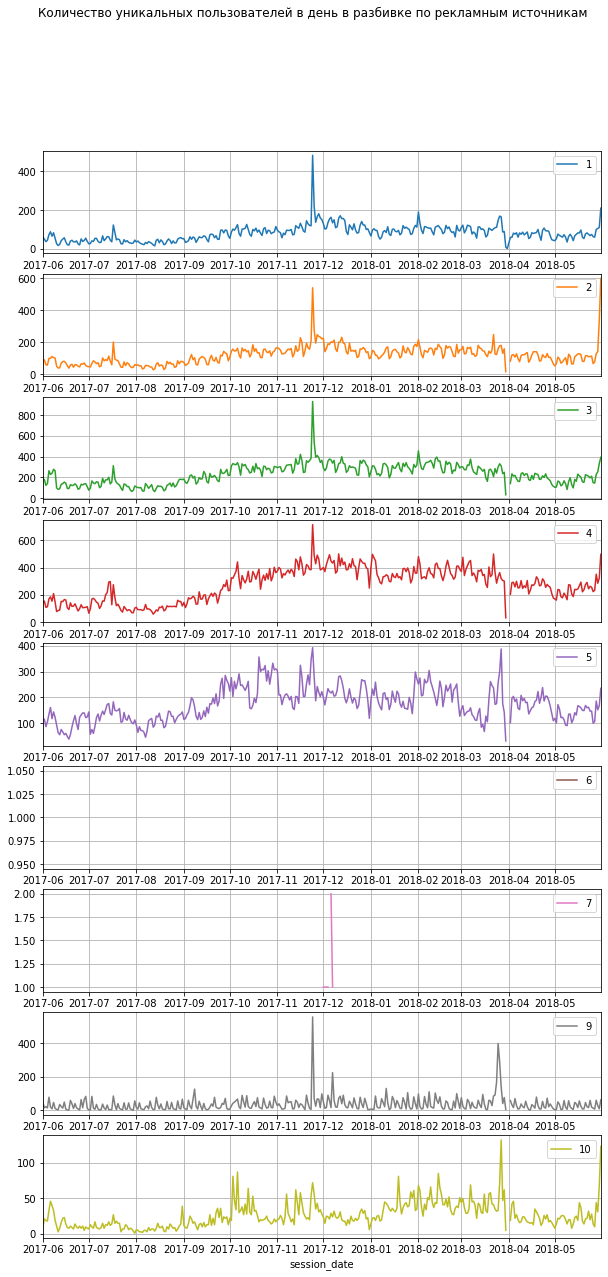

In [59]:
#Строим сводную таблицу по каждому дню и рекламному источнику, по своднику рисуем график количества уникальных пользователей
ax = visits.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='nunique')\
           .plot(grid=True, figsize=(10, 20), subplots = True, sharex=False,  title='Количество уникальных пользователей в день в разбивке по рекламным источникам')

31 марта 2018 был зафиксирован **один** уникальный пользователь, скорее, благодаря рекламному источнику *№1*.

24 ноября 2017 - **3 319** пользователей из источников *№1*, *№2*, *№3*, *№9*.

Еще один "выброс" в 17 июля 2017. Несмотря на "мертвый театральный сезон" на сайте было зафиксировано 1138 пользователей из рекламных источников *№1*, *№2*, *№3*, *№4*.

In [60]:
#ax = visits.query('device == "desktop"')\
#            .pivot_table(index='session_date', columns=('device','source_id'), values='uid', aggfunc='nunique')\
#            .plot(grid=True, figsize=(10, 20), subplots = True, sharex=False,  title='Количество уникальных пользователей desktop версии в день в разбивке по рекламным источникам')

In [61]:
#ax = visits.query('device == "touch"')\
#            .pivot_table(index='session_date', columns=('device','source_id'), values='uid', aggfunc='nunique')\
#            .plot(grid=True, figsize=(10, 20), subplots = True, sharex=False,  title='Количество уникальных пользователей touch девайсов в день в разбивке по рекламным источникам')

Перейдем к рассчету метрики **WAU** - количества уникальных пользователь в неделю.

In [62]:
#Группируем визиты по году, неделе и вычисляем среднее количество уникальных пользователей для каждой недели
wau = visits.groupby(['session_year', 'session_week'])\
            .agg({'uid': 'nunique'})\
            .mean()
int(wau)

5716

In [63]:
#Группируем визиты по году, неделе и вычисляем среднее количество уникальных пользователей "touch" для каждой недели 
wau_touch = visits.query('device == "touch"')\
                .groupby(['session_year', 'session_week'])\
                .agg({'uid': 'nunique'})\
                .mean()
int(wau_touch)

1634

In [64]:
#Группируем визиты по году, неделе и вычисляем среднее количество уникальных пользователей "desktop" для каждой недели 
wau_desktop = visits.query('device == "desktop"')\
                .groupby(['session_year', 'session_week'])\
                .agg({'uid': 'nunique'})\
                .mean()
int(wau_desktop)

4129

Количество уникальных пользователей в неделю составило - *5 716* **WAU**! 

**WAU** для пользователей на *touch* составила - **1 634**, а для *desktop* в несколько раз выше - **4 129**

Text(0.5, 0, 'Дата, неделя')

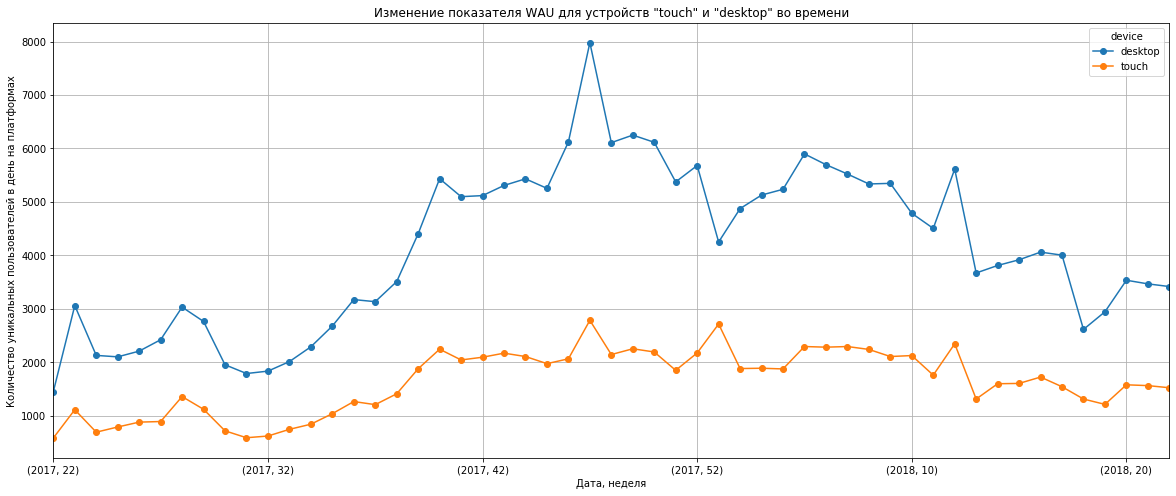

In [65]:
#По сводной таблице строим график числа уникальных пользователей на каждую неделю в разрезе устройств
ax = visits.pivot_table(index=['session_year', 'session_week'], columns='device', values='uid', aggfunc='nunique')\
            .plot(style ='-o', grid=True, figsize=(20, 8), title = 'Изменение показателя WAU для устройств "touch" и "desktop" во времени')
#Подписываем оси
ax.set_ylabel('Количество уникальных пользователей в день на платформах')
ax.set_xlabel('Дата, неделя')

Самая "удачная" по привличению уникальных пользователей была **47 неделя**, почти всегда на промежутке кривая *touch* была схожа с кривой по числу уникальных пользователей устройства *desktop*. Исключения **1 неделя** и **18 неделя** - у *desktop* спад новых уникальных заходов, тогда как у *touch* рост или без существенных изменений.

In [66]:
#visits.pivot_table(index=['session_year', 'session_week'], columns='device', values='uid', aggfunc='nunique')

Перейдем к нашей третьей метрике - **MAU** и посмотрим изменение ее во времени.

In [67]:
#Группируем данные по году и месяцу, считаем уникальные "uid" и находим среднее значение по каждому месяцу
mau = visits.groupby(['session_year', 'session_month'])\
            .agg({'uid': 'nunique'})\
            .mean()
int(mau)

23228

In [68]:
#По выборке устройста "touch" группируем данные по году и месяцу, считаем уникальные "uid" пользователей, находим среднее значение
mau_touch = visits.query('device == "touch"')\
                .groupby(['session_year', 'session_month'])\
                .agg({'uid': 'nunique'})\
                .mean()
int(mau_touch)

6825

In [69]:
#По выборке устройста "desktop" группируем данные по году и месяцу, считаем уникальные "uid" пользователей, находим среднее значение
mau_desktop = visits.query('device == "desktop"')\
                .groupby(['session_year', 'session_month'])\
                .agg({'uid': 'nunique'})\
                .mean()
int(mau_desktop)

16724

В среднем, **23 228** уникальных пользователей пользовались сервисом Яндекс.Афиши, из них **6 825** пользователей с устройства *touch*, и **16 724** - с *desktop*

Text(0.5, 0, 'Дата, месяц')

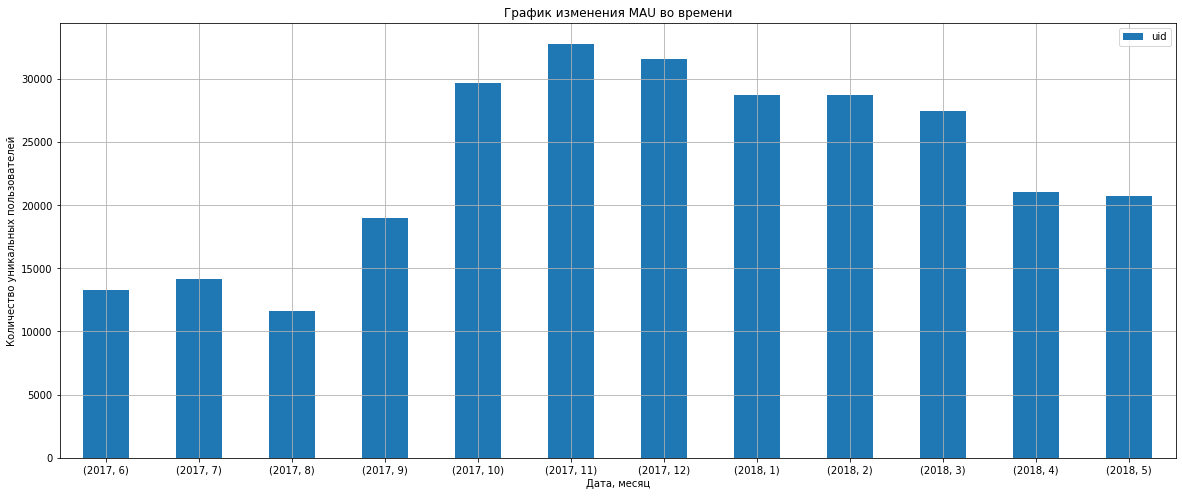

In [70]:
#Строим график по группировке числа уникальных "uid" пользователей
ax = visits.groupby(['session_year', 'session_month'])\
           .agg({'uid': 'nunique'})\
           .plot(kind = 'bar', grid=True, figsize=(20, 8), rot=0, title = 'График изменения MAU во времени')
#Подписываем оси графика
ax.set_ylabel('Количество уникальных пользователей')
ax.set_xlabel('Дата, месяц')

Наибольшее количество пользователей наблюдалось в *октябре*, *ноябре* и *декабре 2017*, наименьше всего было пользователей в *августе 2017*.

Text(0.5, 0, 'Месяц, тип девайса')

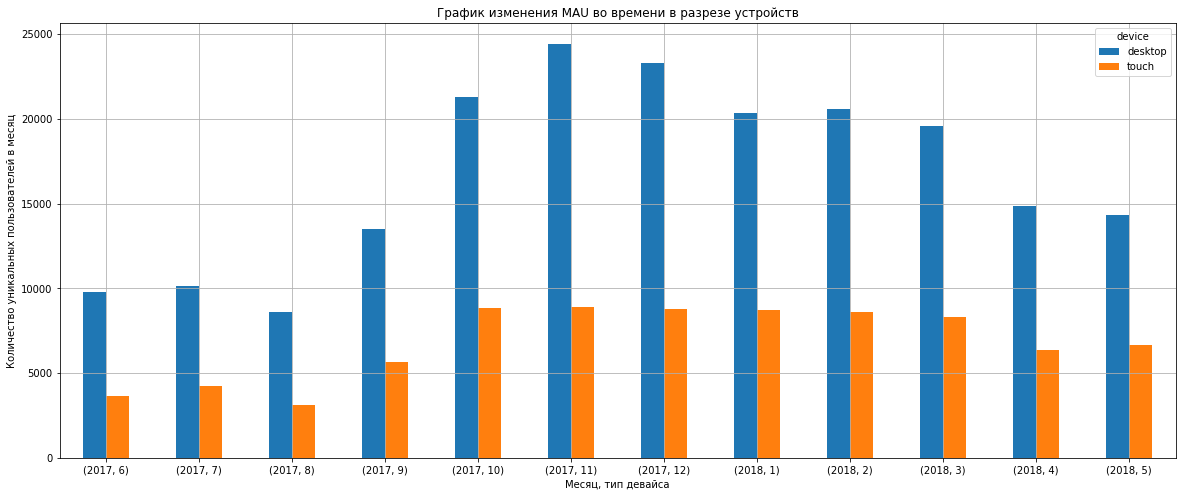

In [71]:
#Собираем сводную таблицу с данными количества уникальных "uid" на каждом устройстве в разрезе месяца
ax = visits.pivot_table(index=['session_year', 'session_month'], columns='device', values='uid', aggfunc='nunique')\
            .plot(kind = 'bar', grid=True, figsize=(20, 8), rot=0, title = 'График изменения MAU во времени в разрезе устройств')
#Подписываем оси графика
ax.set_ylabel('Количество уникальных пользователей в месяц')
ax.set_xlabel('Месяц, тип девайса')

График изменения **MAU** во времени в разрезе устройств показал, что в *августе 2017* было зафиксировано наименьшее количество пользователей в сервисе на обоих типах устройства. 

Пользователи устройства *desktop* были наиболее активны в *ноябре 2017*, в последующие месяцы активность плавно уменьшалась. 

Пользователи на устройстве типа *touch* были почти одинаково активны с *октября 2017* по *март 2018*.

 <a class="anchor" id="section_2_1_2"></a>
##### Определяем регулярность сессий в день
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Определяем, сколько раз за день пользователи в среднем заходят на сайт и смотрим как изменяется эта метрика с течением времени

In [72]:
#В переменной "sessions_per_user" сохраняем таблицу с данными по общему количеству сессий и уникальному кол-ву пользователей, сгруппированную по дате
sessions_per_user = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})

#Переименовываем столбцы полученной таблицы
sessions_per_user.columns = ['n_sessions', 'n_users']

#Считаем среднее количество сессий на пользователя
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

In [73]:
#Выведем на экран максимально значение "сессий на пользователя"
sessions_per_user['sess_per_user'].max()

1.2178366978005424

In [74]:
#Выведем на экран минимальное значение "сессий на пользователя"
sessions_per_user['sess_per_user'].min()

1.0

In [75]:
#Выведем на экран первые 5 максимальных значений "сессий на пользователя"
sessions_per_user.sort_values(by = 'sess_per_user', ascending = False).head(5)

,n_sessions,n_users,sess_per_user
session_date,,,
2017-11-24,4042,3319,1.217837
2017-11-28,1746,1493,1.169457
2017-11-25,2089,1817,1.149697
2018-02-01,1878,1640,1.145122
2017-11-29,1480,1296,1.141975


Большая посещаемость зафиксирована *ноябре 2017*. Посмотрим наглядно как изменялась эта метрика во времени

Text(0.5, 0, 'Дата, день')

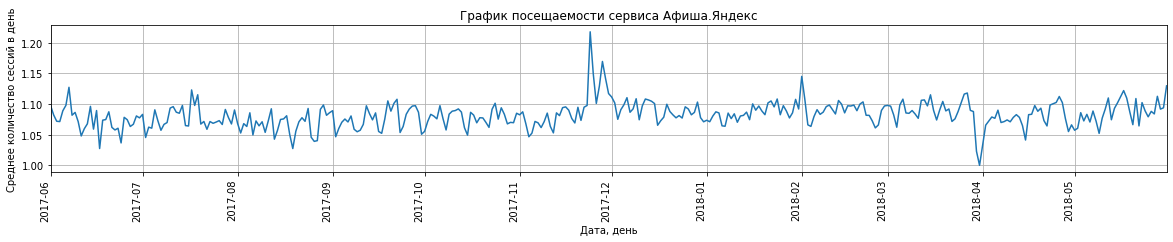

In [76]:
#Строим график по значениям "sess_per_user" на каждый день
ax = sessions_per_user['sess_per_user'].plot(grid=True, figsize=(20, 3), rot=90, title = 'График посещаемости сервиса Афиша.Яндекс')

#Подписываем оси
ax.set_ylabel('Среднее количество сессий в день')
ax.set_xlabel('Дата, день')

Давайте посомотрим одинаково ли среднее значение посещаемости для устройств *touch* и *desktop*. Для этого проделаем все те же расчеты, только в разбивке по устройствам.

In [77]:
#В переменной "sessions_per_user_device" сохраняем таблицу с данными по общему количеству сессий и уникальному кол-ву пользователей, сгруппированную по дате
sessions_per_user_device = visits.groupby(['session_year', 'session_month', 'device']).agg({'uid': ['count','nunique']})

#Переименовываем столбцы полученной таблицы
sessions_per_user_device.columns = ['n_sessions', 'n_users']

#Считаем среднее количество сессий на пользователя
sessions_per_user_device['sess_per_user'] = sessions_per_user_device['n_sessions'] / sessions_per_user_device['n_users']

In [78]:
#Выведем на экран полученную таблицу
sessions_per_user_device

n_sessions  n_users  sess_per_user
session_year session_month device                                     
2017         6             desktop       12358     9761       1.266059
                           touch          4147     3655       1.134610
             7             desktop       12950    10145       1.276491
                           touch          4878     4223       1.155103
             8             desktop       10854     8611       1.260481
                           touch          3501     3132       1.117816
             9             desktop       17356    13509       1.284773
                           touch          6551     5679       1.153548
             10            desktop       27392    21286       1.286855
                           touch         10511     8856       1.186879
             11            desktop       32917    24439       1.346905
                           touch         11052     8913       1.239987
             12            desktop       31112    23294       1.335623
                           touch         10871     8785       1.237450
2018         1             desktop       26577    20350       1.305995
                           touch         10362     8741       1.185448
             2             desktop       27077    20574       1.316079
                           touch         10105     8590       1.176368
             3             desktop       25861    19574       1.321191
                           touch          9818     8303       1.182464
             4             desktop       19231    14844       1.295540
                           touch          7284     6387       1.140442
             5             desktop       18882    14312       1.319312
                           touch          7753     6647       1.166391

In [79]:
#Выведем на экран максимальные значения сессий в разбивке по девайсам
sessions_per_user_device.groupby('device')['sess_per_user'].max()

device
desktop    1.346905
touch      1.239987
Name: sess_per_user, dtype: float64

In [80]:
#Выведем на экран минимальные значения сессий в разбивке по девайсам
sessions_per_user_device.groupby('device')['sess_per_user'].min()

device
desktop    1.260481
touch      1.117816
Name: sess_per_user, dtype: float64

Как мы видим,  посещаемость отличается от показателя посещаемости в разрезе устройств.
Так с утройства *desktop* заходы осуществляются чаще, чем на с утройства *touch*.

Давайте посмотрим как долго длятся сессии пользователей.

<a class="anchor" id="section_2_1_3"></a>
##### Длительность одной сессии
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Рассчитаем среднюю продолжительность пользовательской сессии *ASL (average session length)* за весь период и посмотрим как продолжительность сессий распределена по пользователям.

In [81]:
#Рассчитаем длительность сессий как разницу между ее начальным и конечным временем в секундах
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

#Находим самое часто встречающиеся значение и сохраняем его в переменную
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

Text(0.5, 0, 'Количество секунд')

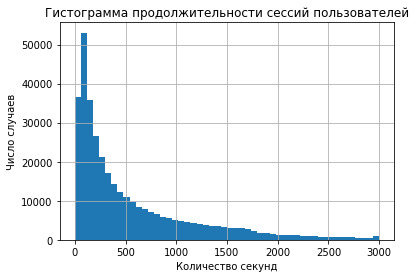

In [82]:
#Строим гистограмму с наиболее встречающимися значениями продолжительности сессий
ax = visits['session_duration_sec'].hist(bins = 50, range = (0, 3000))

#Подписываем оси 
ax.set_title('Гистограмма продолжительности сессий пользователей')
ax.set_ylabel('Число случаев')
ax.set_xlabel('Количество секунд')

Наши пользователи проводили в сервисе не дольше минуты. Однако, в нашей выборке есть и значения типа - *0 секунд*

In [83]:
#Выводим на экран любую строку из таблицы "visits"
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_week,session_month,session_date,session_duration_sec
246137,desktop,2018-03-06 13:25:00,10,2018-03-06 13:19:00,17842100233041586114,2018,10,3,2018-03-06,360


In [84]:
#Понижаем разрядность значений в столбце "session_duration_sec"
visits['session_duration_sec'] = pd.to_numeric(visits['session_duration_sec'], downcast = 'signed')

In [85]:
#Создаем выборку, в которой останутся данные только тех пользователей, у которых продолжительность сессии больше нуля
visits_with_duration = visits[visits['session_duration_sec'] > 0]

Возможно, пользователи сервиса Яндекс.Афиши одинаково долго пользуются сервисам на устройствах? Давайте проведем стат.анализ и сравним две выборки и проверим нашу гипотезу.

In [86]:
#Создадим срезы для каждого типа устройств и сохраним их в переменной
desktop_visits = visits_with_duration.query('device == "desktop"')
touch_visits = visits_with_duration.query('device == "touch"')

#Из срезов сохраним только значения с продолжительностями сессий
desktop_visits_durations = desktop_visits['session_duration_sec']
touch_visits_durations = touch_visits['session_duration_sec']

alpha = 0.05

#С помощью T-теста сравним две полученные выборки
results = st.ttest_ind(desktop_visits_durations, touch_visits_durations, equal_var=False)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


In [87]:
#Выведем на экран среднее значение продолжительности сессии на усттройстве "desktop"
desktop_visits_durations.mean()

773.7558335217141

In [88]:
#Выведем на экран среднее значение продолжительности сессии на усттройстве "touch"
touch_visits_durations.mean()

548.1421253894816

Пользователи с устройства *desktop* проводят больше времени в сервисе, чем пользователи на *touch*.
Так, в среднем, пользователи на *desktop* находятся в сервисе - **774 секунды** (почти 13 минут), а пользователи на *touch* - **548 секунд** (9 минут).

<a class="anchor" id="section_2_1_4"></a>
##### Считаем `Retention Rate`, применяя когортный анализ 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Давайте посмотрим как часто наши пользователи возвращаются к нам в сервис, для этого мы применим когортный анализ и затем рассчитаем показатель возвращаемости/удержания клиентов - *Retention Rate*.

In [89]:
# Определим первый месяц когда пользователь совершил действие
first_activity_month = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()

In [90]:
# Меняем формат столбца start_ts
first_activity_month['start_ts'] = first_activity_month['start_ts'].astype('datetime64[M]')

In [91]:
#Присвоим имена колонкам в полученной таблице
first_activity_month.columns = ['uid', 'first_activity_month']

In [92]:
#Переименуем полученную серию данных для последующего объединения
first_activity_month.name = 'first_activity_month'

In [93]:
#Добавляем данные о первом месяце посещения сервиса в общую таблицу
visits = visits.merge(first_activity_month, on='uid')

In [94]:
#Выводим первые пять строк таблицы
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_week,session_month,session_date,session_duration_sec,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,51,12,2017-12-20,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,8,2,2018-02-19,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,26,7,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,20,5,2018-05-20,1440,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,10,3,2018-03-09,1680,2018-03-01


In [95]:
#Присваиваем lifetime для каждой сессии
visits['cohort_lifetime'] = visits['session_date'].astype('datetime64[M]') - visits['first_activity_month'].astype('datetime64[M]')

In [96]:
#Выводим первые пять строк таблицы
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_week,session_month,session_date,session_duration_sec,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,51,12,2017-12-20,1080,2017-12-01,0 days
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,8,2,2018-02-19,1680,2018-02-01,0 days
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,26,7,2017-07-01,0,2017-07-01,0 days
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,20,5,2018-05-20,1440,2018-03-01,61 days
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,10,3,2018-03-09,1680,2018-03-01,0 days


In [97]:
#В качестве делителя используем месяц
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')

In [98]:
#Округляем до целых и приводим к формату "int"
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

In [99]:
#Группируем данные по когорте и считаем для каждой когорты количество активных пользователей на определенный месяц
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [100]:
#Рассчитаем число пользователей в нулевом месяце
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [101]:
#Переименовываем столбец для удобства "Число пользователей в когорте"
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [102]:
#Добавляем в таблицу с когортами общую сумму пользователей этой когорты
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [103]:
#Разделим число активных пользователей на число пользователей когорты
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

In [104]:
#Собираем сводную таблицу
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [105]:
#Добавляем среднее значение метрики когорт
retention_pivot.loc['mean'] = retention_pivot.mean()

In [106]:
#Выводим сводную таблицу на экран
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01 00:00:00,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01 00:00:00,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01 00:00:00,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01 00:00:00,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01 00:00:00,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01 00:00:00,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01 00:00:00,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01 00:00:00,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01 00:00:00,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,


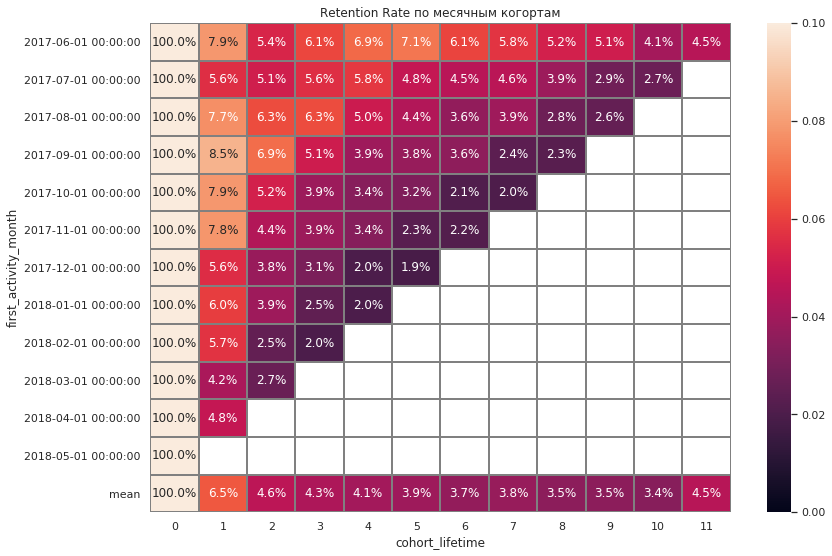

In [107]:
# Строим тепловую карту по сводной таблице
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1)

*Retention Rate* убывает по когортам с течением времени и растет примерно на 5-6 месяце жизни. Нужно учитывать выраженную сезонность сервиса Яндекс.Афиши. Если для когорты пользователей, пришедших в июне  Retention Rate в первый месяц составляет 9,5%, то для пользователей, пришедших в октябре — уже 1,4%. Так, за 5 месяцев коэффициент удержания существенно снизился.

Вероятно, что с каждой новой когортой поведение покупателей меняется.

 <a class="anchor" id="section_2_2"></a>
#### Анализируем продажи
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Для анализа продаж нам необходимо будет объединить таблицу c визитами "*visits*" с данными о заказах "*orders*".

Так мы сможем определить в какой момент люди начинают покупать, как часто и на какую сумму они совершают заказы.
Эта информация поможет нам понять сколько денег принесли пользователи.

In [108]:
#К таблице с визитами присоединяем информацию о покупках по каждому uid
visits = visits.merge(orders, on = 'uid')

In [109]:
#Выведем на экран любую строку с данными
visits.sample()

,device,end_ts,source_id,start_ts,uid,session_year,session_week,session_month,session_date,session_duration_sec,first_activity_month,cohort_lifetime,buy_ts,revenue
370162,desktop,2017-08-31 14:28:00,1,2017-08-31 14:19:00,3644482766749211722,2017,35,8,2017-08-31,540,2017-06-01,2,2017-12-29 15:32:00,7.33


Мы объединили две таблицы *visits* и *orders* для нашего дальнейшего анализа.

<a class="anchor" id="section_2_2_1"></a>
##### Среднее время от первого посещения сайта до покупки
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Выясним, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.
Для этого создадим таблицу с информацией о дате первого визита и первой покупки для каждого пользователя и найдем разницу между ними.

In [110]:
#Соберем информацию о первом визите пользователя и сохраним ее в переменную first_visits_ts
first_visits_ts = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()

In [111]:
#Выведем на экран первую строчку плучившейся таблицы
first_visits_ts.head(1)

,uid,start_ts
0,313578113262317,2017-09-18 22:49:00


In [112]:
#Переименуем колонки
first_visits_ts.columns = ['uid', 'first_visits_ts']

In [113]:
#Изменим формат данных о первом визите
first_visits_ts['first_visits_ts'] = pd.to_datetime(first_visits_ts['first_visits_ts'], format ="%Y-%m-%d %H:%M:%S")

In [114]:
#Соберем информацию о времени первой покупки пользователя и сохраним ее в переменную first_orders_ts
first_orders_ts = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()

In [115]:
#Выведем на экран первую строчку плучившейся таблицы
first_orders_ts.head(1)

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00


In [116]:
#Переименуем колонки
first_orders_ts.columns = ['uid', 'first_orders_ts']

In [117]:
#Изменим формат данных о первом визите
first_orders_ts['first_orders_ts'] = pd.to_datetime(first_orders_ts['first_orders_ts'], format ="%Y-%m-%d %H:%M:%S")

In [118]:
#Объеденим таблицы first_orders_ts и first_visits_ts по uid
first_visit_and_order = first_visits_ts.merge(first_orders_ts, on = 'uid')

In [119]:
#Выведем первые 5 строк таблицы first_visit_and_order
first_visit_and_order.head()

,uid,first_visits_ts,first_orders_ts
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [120]:
#Добавим в таблицу first_visit_and_order столбец с разницей между first_orders_ts и first_visits_ts в днях
first_visit_and_order['time_difference'] = (first_visit_and_order['first_orders_ts'] - first_visit_and_order['first_visits_ts'])

In [121]:
#Выведем первые пять строк таблицы first_visit_and_order
first_visit_and_order.head()

,uid,first_visits_ts,first_orders_ts,time_difference
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


In [122]:
#Выведем на экран минимальное значение
first_visit_and_order['time_difference'].min()

Timedelta('0 days 00:00:00')

In [123]:
#Выведем на экран максимальное значение
first_visit_and_order['time_difference'].max()

Timedelta('363 days 07:04:00')

Для наглядности полученных показателей построим гистрограмму, максимальное время от визита до покупки - почти год - **363 дня и 7 часов**. Самое минимальное принимает значение - **0**. 

Вероятно, пользователь запланировал покупку заранее или достаточно хорошо разбирается в сервисе Яндекс.Афиша, что успевает совершить покупку за *60 секунд* (предоставленные данные включают в себя только значение с точностью до минуты, секунды не учтены).

Text(0.5, 0, 'Количество минут')

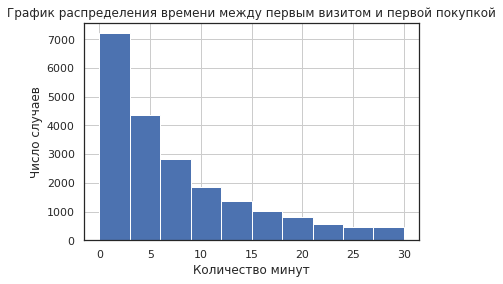

In [124]:
#Строим гистограмму значений времени между первым посещением и первой покупкой
ax = (first_visit_and_order['time_difference']/np.timedelta64(1, 'm')).hist(range = (0, 30), bins = 10)

#Подписываем оси 
ax.set_title('График распределения времени между первым визитом и первой покупкой')
ax.set_ylabel('Число случаев')
ax.set_xlabel('Количество минут')

In [125]:
#Находим самое часто встречающееся в секундах
(first_visit_and_order['time_difference']/np.timedelta64(1, 'm')).mode()

0    1.0
dtype: float64

In [126]:
#Находим медианное значение в секундах
(first_visit_and_order['time_difference']/np.timedelta64(1, 'm')).median()

16.0

В среднем пользователям достаточно до ***16 минут*** для совершения свой первой покупки при первом посещении сайта.

<a class="anchor" id="section_2_2_2"></a>
##### Считаем среднее количество покупок на одного клиента за 6 месяцев, применяя когортный анализ 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

In [131]:
#Выведем на экран первые 5 строк таблицы orders
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Объединим две таблицы в одну, что бы у нас была полная информация о пользователе - дата первой покупки, что бы определить когорту, и дата текущей покупки, что бы можно было понять как изменяется поведение пользователя во времени.

In [132]:
#Добавляем первый месяц покупки из таблицы first_orders_ts
orders = orders.merge(first_orders_ts,on='uid')

In [133]:
#Форматируем столбец в нужный типа данных
orders['first_orders_ts'] = orders['first_orders_ts'].astype('datetime64[M]')

In [134]:
#Найдем количество новых покупателей ежемесячно
cohort_sizes = orders.groupby('first_orders_ts').agg({'uid': 'nunique'}).reset_index()

In [135]:
#Переименуем колонку uid
cohort_sizes = cohort_sizes.rename(columns={'uid':'cohort_users'})

In [136]:
#Выведем на экран таблиц cohort_sizes
cohort_sizes

,first_orders_ts,cohort_users
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [137]:
#Формируем когорты
cohorts = orders.groupby(['first_orders_ts', 'buy_ts']).agg({'revenue': 'count'}).reset_index()

In [138]:
#Соединяем две полученные таблицы
report = pd.merge(cohort_sizes, cohorts, on='first_orders_ts')

In [139]:
#Определяем возраст когорты и приводим к нужному типу данных
report['age'] = (report['buy_ts'] - report['first_orders_ts']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [140]:
#Выводим первые пять строк таблицы report
report.head()

,first_orders_ts,cohort_users,buy_ts,revenue,age
0,2017-06-01,2023,2017-06-01 00:10:00,1,0
1,2017-06-01,2023,2017-06-01 00:25:00,1,0
2,2017-06-01,2023,2017-06-01 00:27:00,1,0
3,2017-06-01,2023,2017-06-01 00:29:00,1,0
4,2017-06-01,2023,2017-06-01 07:58:00,1,0


In [141]:
#Считаем среднее количество покупок
report['avg_order'] = report['revenue'] / report['cohort_users']

In [142]:
#Формируем полученные данные в сводную таблицу
result = report.pivot_table(
        index='first_orders_ts', 
        columns='age', 
        values='avg_order', 
        aggfunc='sum')

#Добавляем среднее значение метрики когорт
result.loc['mean'] = result.mean()

In [143]:
#Выводим полученный отчет накопительным итогом
result.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11,12
first_orders_ts,,,,,,,,,,,,,
2017-06-01 00:00:00,0.74,1.22,1.29,1.39,1.53,1.63,1.77,1.87,1.97,2.07,2.13,2.17,2.19
2017-07-01 00:00:00,0.56,1.16,1.21,1.28,1.32,1.36,1.4,1.43,1.46,1.48,1.49,1.51,
2017-08-01 00:00:00,0.42,1.16,1.23,1.31,1.36,1.41,1.45,1.5,1.54,1.58,1.6,,
2017-09-01 00:00:00,0.46,1.19,1.24,1.32,1.36,1.4,1.44,1.47,1.49,1.5,,,
2017-10-01 00:00:00,0.62,1.18,1.24,1.27,1.3,1.33,1.34,1.36,1.38,,,,
2017-11-01 00:00:00,0.43,1.25,1.3,1.35,1.39,1.41,1.43,1.45,,,,,
2017-12-01 00:00:00,0.56,1.18,1.24,1.28,1.31,1.33,1.34,,,,,,
2018-01-01 00:00:00,0.49,1.16,1.21,1.24,1.27,1.28,,,,,,,
2018-02-01 00:00:00,0.63,1.16,1.2,1.21,1.22,,,,,,,,


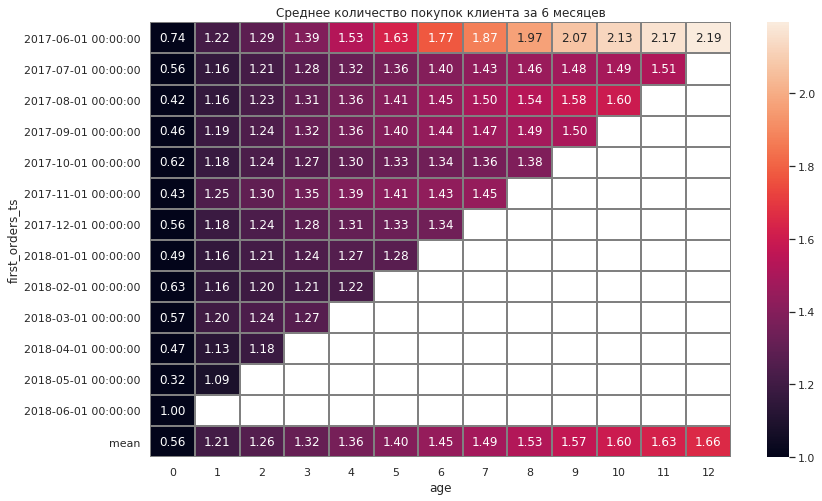

In [144]:
# Строим тепловую карту по сводной таблице
sns.set(style='white')
plt.figure(figsize=(13, 8))
plt.title('Среднее количество покупок клиента за 6 месяцев')
sns.heatmap(result.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=1)

Мы видим выраженную сезонность сервиса: в летний период идет спад активности и совершения покупок, зимой же, напротив, покупки совершаются чаще.

В среднем, за 6 месяцев покупатель совершает **1,45** покупок.

<a class="anchor" id="section_2_2_3"></a>
##### Средний чек пользователя
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Рассчитаем среднюю выручку пользователя и построим график изменения метрики с течением времени.

Для рассчета средней выручки разделим общую сумму денег на общее число покупок.

In [145]:
#Посмотрим какие данные содержит таблица orders на этом этапе 
orders.head(1)

,buy_ts,revenue,uid,first_orders_ts
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01


In [148]:
#Форматируем столбец под нужный нам формат
orders['buy_ts'] = orders['buy_ts'].astype('datetime64[M]')

In [149]:
#Группируем полученные данные, суммируем выручку по каждому пользователю и считаем выручку на пользователя
orders_grouped_by_cohorts = orders.groupby(['first_orders_ts','buy_ts']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts['revenue_per_player'] = orders_grouped_by_cohorts['revenue']/orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

In [150]:
#Формируем когорты
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['buy_ts'] - orders_grouped_by_cohorts['first_orders_ts']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [151]:
#Строим сводную таблицу средних чеков наших когорт
lifetime_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_orders_ts',
    columns='cohort_lifetime',
    values='revenue_per_player',
    aggfunc='mean')

lifetime_pivot.loc['mean'] = lifetime_pivot.mean()

In [152]:
#Выводим полученную таблицу на экран
lifetime_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_ts,,,,,,,,,,,,
2017-06-01 00:00:00,4.724414,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415
2017-07-01 00:00:00,6.010219,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08-01 00:00:00,5.276518,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,,
2017-09-01 00:00:00,5.644529,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,,,
2017-10-01 00:00:00,5.003733,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,,,,
2017-11-01 00:00:00,5.154683,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,,,,,
2017-12-01 00:00:00,4.738191,7.81658,39.366,48.1351,27.4314,23.5184,,,,,,
2018-01-01 00:00:00,4.135636,8.72123,12.3655,11.1998,4.69956,,,,,,,
2018-02-01 00:00:00,4.156987,8.61,4.94241,6.94103,,,,,,,,


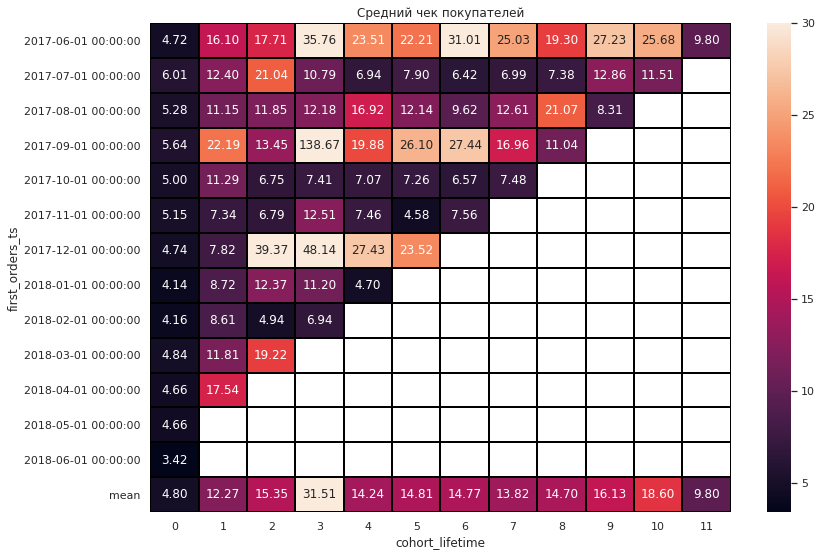

In [153]:
#Строим тепловую карту среднего чека
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(lifetime_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black', vmax =30) 

По полученным данным можно сделать вывод, что *сентябрьская* и *декабрьская* когорты самые выгодные по среднему чеку. В сентябрьской когорте наблюдается самый высокий средний чек в декабре- **138,67**.

Самые низкий средний чек наблюдается у когорт - *октября* и *ноября*.

<a class="anchor" id="section_2_2_4"></a>
##### Выясняем, как меняется во времени накопительный LTV по когортам. Сравниваем средний LTV по когортам за 6 месяцев 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

In [154]:
# Выводим на экран первую строку таблицы
orders.head(1)

,buy_ts,revenue,uid,first_orders_ts
0,2017-06-01,17.0,10329302124590727494,2017-06-01


In [155]:
# Формируем когорты по числу уникальных пользователей и оставляем только те когорты, которым 6 и более месяцев
cohort_sizes = orders.groupby('first_orders_ts').agg({'uid': 'nunique'}).reset_index()

#cohort_sizes = cohort_sizes[:7]

In [156]:
# Формируем данные по выручке
cohorts = orders.groupby(['first_orders_ts', 'buy_ts']).agg({'revenue': 'sum'}).reset_index()

In [157]:
# Объединяем две таблицы cohort_sizes и cohorts
report = pd.merge(cohort_sizes, cohorts, on='first_orders_ts')

# Вычисляем средний ltv
report['lifetime'] = (report['buy_ts'] - report['first_orders_ts']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
report['ltv'] = report['revenue'] / report['uid']

result = report.pivot_table(
        index='first_orders_ts', 
        columns='lifetime', 
        values='ltv', 
        aggfunc='mean')

#Добавляем среднее значение метрики когорт
result.loc['mean'] = result.mean()

result.cumsum(axis=1).round(2).fillna('') 

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_ts,,,,,,,,,,,,
2017-06-01 00:00:00,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01 00:00:00,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01 00:00:00,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01 00:00:00,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01 00:00:00,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01 00:00:00,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01 00:00:00,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01 00:00:00,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01 00:00:00,4.16,4.44,4.51,4.59,,,,,,,,


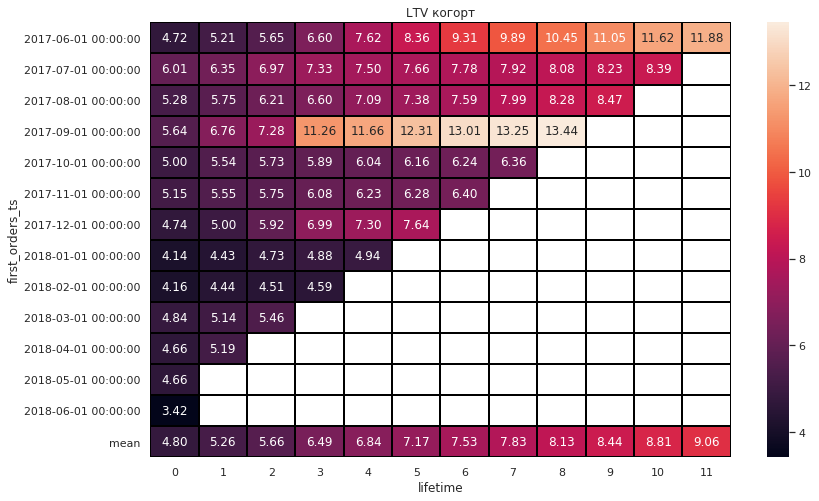

In [158]:
# Строим тепловую карту среднего ltv когорт
plt.figure(figsize=(13, 8))
plt.title('LTV когорт')
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black') 

In [159]:
# Считаем средний LTV
result.cumsum(axis=1).mean(axis=0)[5]

7.869119148544609

Также, выделяется *сентябрьская* и *июньская* когорты по показателю LTV, наименьший показатель этой метрики наблюдается в *октябрьской* и *ноябрьской* когортах.

Средний LTV по когортам за 6 месяцев после первой покупки составляет - **7,86**.

Просмотрим LTV в разрезе источников.

In [160]:
# Определяем первый источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

In [161]:
#Выводим на экран первые пять строк таблицы sources
sources.head()

,source_id
uid,
313578113262317,2
1575281904278712,10
2429014661409475,3
2464366381792757,5
2551852515556206,5


In [162]:
# Соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

In [163]:
#Выводим на экран первые пять строк таблицы payers
payers.head()

,uid,first_buy,source_id
0,313578113262317,2018-01-01,2
1,1575281904278712,2017-06-01,10
2,2429014661409475,2017-10-01,3
3,2464366381792757,2018-01-01,5
4,2551852515556206,2017-11-01,5


In [164]:
# Рассчитываем ltv
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

In [165]:
# Добавляем информацию о когортах
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
cohort_sizes

,cohort_size
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


In [166]:
#Считаем Ltv когорт в разрезе источников
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')

In [167]:
#Выводим таблицу на экран
ltv

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244694,7.166385,7.953846,8.681828,9.086419,9.339275,9.596815,9.963007,10.291058,10.484905,10.615084,10.724577
2,6.610838,8.028970,9.635429,11.248500,11.949405,12.480902,12.847086,13.044325,13.176393,13.242121,13.354762,13.383804
3,4.488593,4.758397,4.903573,5.002216,5.073268,5.120813,5.147825,5.172679,5.191353,5.198539,5.202970,5.204931
4,4.555284,4.742112,4.837758,4.969370,5.070009,5.180220,5.352530,5.392929,5.411978,5.451280,5.503279,5.506685
5,4.840904,5.093303,5.299071,6.799774,6.998036,7.241711,7.367771,7.454008,7.504846,7.572885,7.586095,7.592557
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945497,5.054072,5.136324,5.267739,5.284973,5.293567,5.293567
10,3.163792,3.228857,3.256298,3.294959,3.312897,3.322897,3.331310,3.343574,3.346102,3.348631,3.348631,3.348631


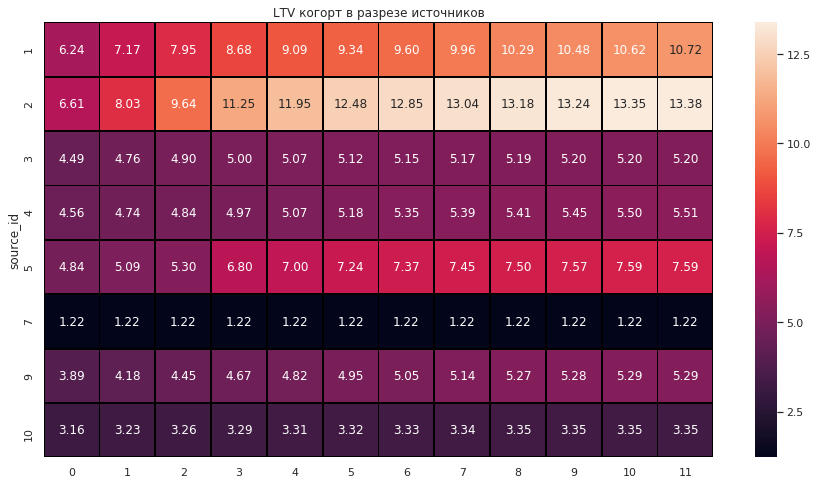

In [168]:
# Строим тепловую карту среднего ltv когорт
plt.figure(figsize=(15, 8))
plt.title('LTV когорт в разрезе источников')
sns.heatmap(ltv.round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black') 

Самые большие по привлечению клиентов источники **3**, **4** и **5**.
Источник **7** привлек одного клиента.

Но ltv показывает, что эффективнее всего работают источники (в порядке убывания) - **2**, **1** и **5**.

<a class="anchor" id="section_2_3"></a>
#### Маркетинг
<a class="anchor" href="#1">Вернуться к оглавлению</a>

В этом разделе мы определим сумму расходов на привлечение клиента из разных источников и посмотрим насколько они окупились.

<a class="anchor" id="section_2_3_1"></a>
##### Выясняем, как траты распределены по источникам и как меняется это распределение во времени
<a class="anchor" href="#1">Вернуться к оглавлению</a>

In [169]:
#Выводим на экран первые пять строк таблицы costs
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.199997
1,1,2017-06-02,62.250000
2,1,2017-06-03,36.529999
3,1,2017-06-04,55.000000
4,1,2017-06-05,57.080002


In [170]:
#Добавляем информацию о месяце расхода
costs['month'] = costs['dt'].astype('datetime64[M]')

In [171]:
#Добавляем информацию о месяце расхода
costs_month = round(costs.groupby('month').agg({'costs': 'sum'}))
costs_month

,costs
month,
2017-06-01,18015.0
2017-07-01,18241.0
2017-08-01,14791.0
2017-09-01,24369.0
2017-10-01,36323.0
2017-11-01,37908.0
2017-12-01,38315.0
2018-01-01,33519.0
2018-02-01,32723.0


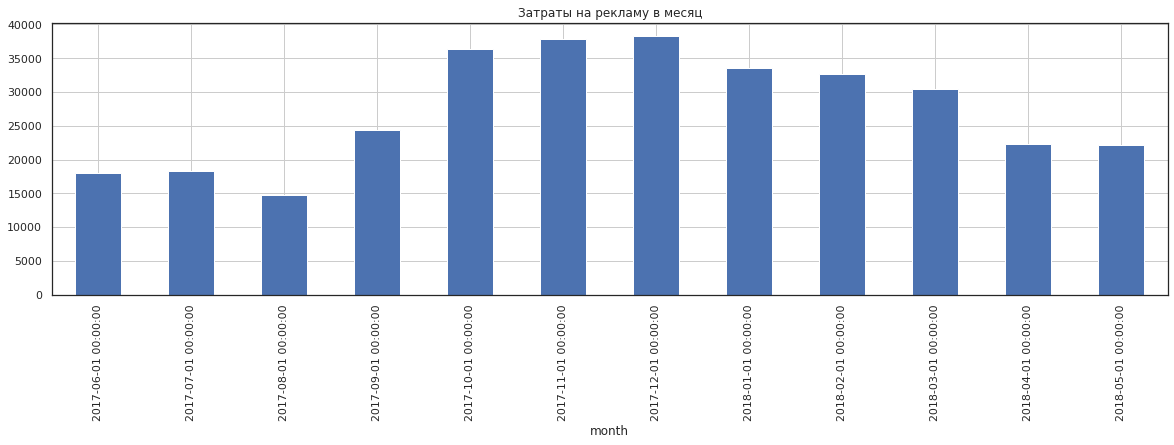

In [172]:
#Строим график затрат на рекламу
round(costs_month.groupby('month')\
      .agg({'costs': (['sum'])}))\
    .plot(kind='bar', grid=True, figsize=(20, 5), rot=90, title = 'Затраты на рекламу в месяц', legend = False)

Самые затратные месяцы - октябрь, ноябрь и декабрь. Август - месяц, в котором было понесено наименьшая сумма расходов.

Давайте просмотрим сколько расходов приходилось на каждый источник

In [173]:
costs_month_source = round(costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum'))
costs_month_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1126.0,2427.0,7732.0,3515.0,2616.0,285.0,314.0
2017-07-01,1073.0,2333.0,7674.0,3530.0,2998.0,303.0,330.0
2017-08-01,952.0,1811.0,6144.0,3217.0,2185.0,249.0,233.0
2017-09-01,1502.0,2986.0,9964.0,5192.0,3849.0,416.0,461.0
2017-10-01,2316.0,4845.0,15737.0,6421.0,5767.0,609.0,627.0
2017-11-01,2445.0,5248.0,17025.0,5389.0,6325.0,683.0,792.0
2017-12-01,2341.0,4898.0,16220.0,7680.0,5873.0,658.0,646.0
2018-01-01,2186.0,4158.0,14809.0,5833.0,5372.0,547.0,614.0
2018-02-01,2204.0,4474.0,14229.0,5712.0,5071.0,552.0,481.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51fde85190>,
      dtype=object)

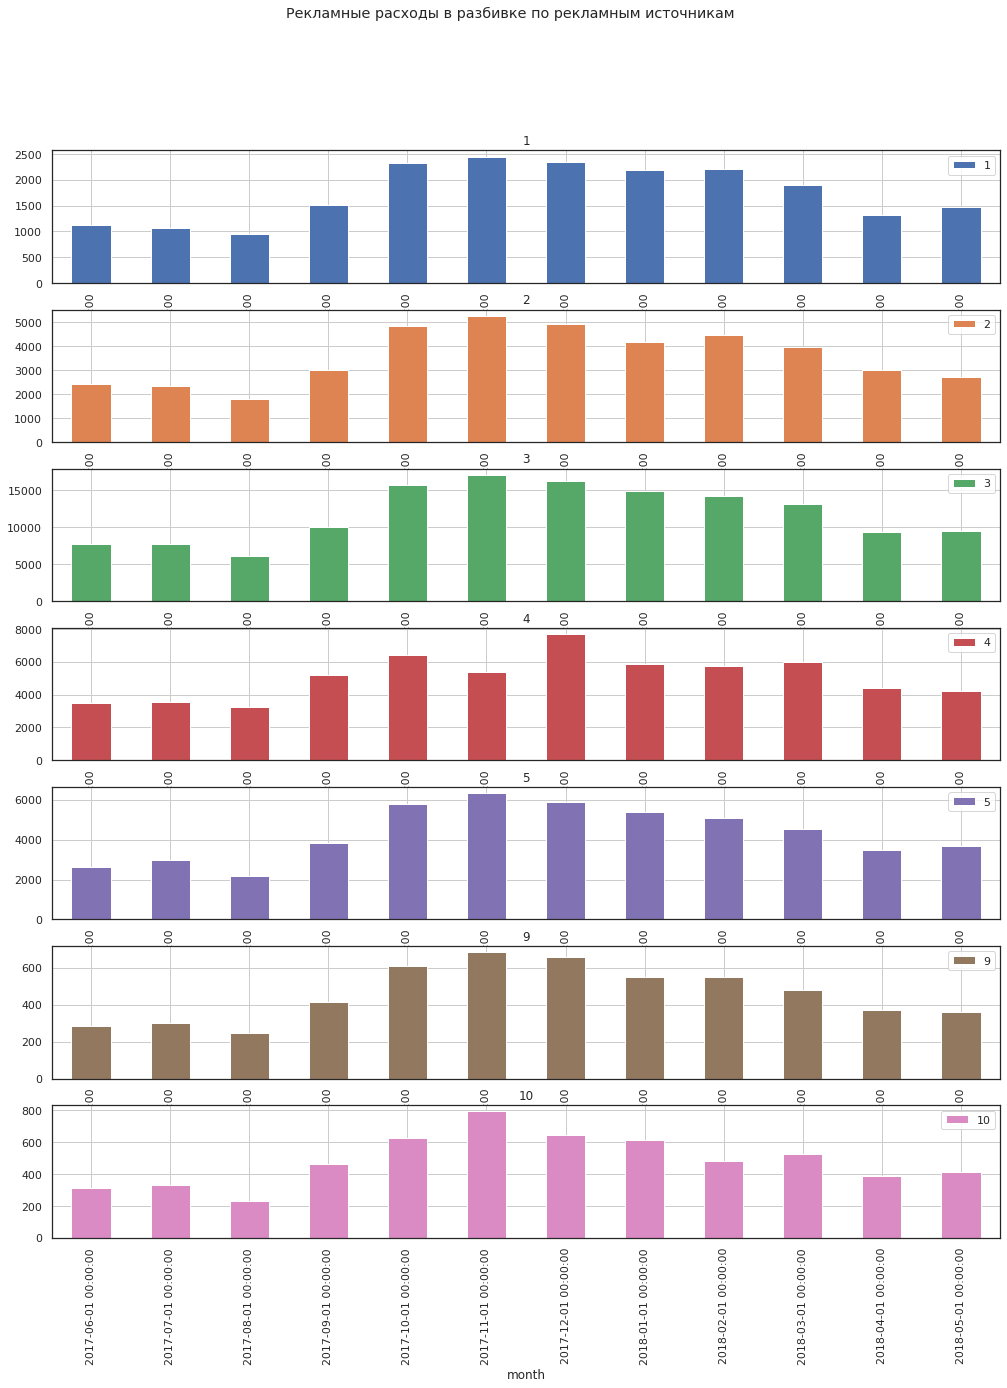

In [174]:
#Строим график затрат на рекламу в разрезе источников
costs_month_source.plot(
    kind='bar', 
    grid=True, 
    figsize=(17, 20), 
    subplots = True, 
    sharex=False,
    rot = 90,
    title='Рекламные расходы в разбивке по рекламным источникам');

Рекламные источники *6* и *7* - не финансировались. *3*, *4* и *5* - самые затратные рекламные источники

<a class="anchor" id="section_2_3_2"></a>
##### Рассчитываем стоимость привлечение одного покупателя из каждого источника трафика 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Для подсчета расходов на одного покупателя, создадим таблицу пользователей, где зафиксируем дату первого захода и источник, с которого осуществился первый заход.

In [181]:
#Формируем когорты
cohort_sizes = orders.groupby('first_orders_ts').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [182]:
#Соединяем две таблицы и сохраняем в таблицу САС
cac = pd.merge(cohort_sizes, costs_month, left_on='first_order_month', right_on='month')

In [183]:
#Переименовываем столбец
cac = cac.rename(columns = {'costs, sum': 'costs'})

In [184]:
#Выводим первые пять строк таблицы cac
cac.head()

,first_order_month,n_buyers,costs
0,2017-06-01,2023,18015.0
1,2017-07-01,1923,18241.0
2,2017-08-01,1370,14791.0
3,2017-09-01,2581,24369.0
4,2017-10-01,4340,36323.0


In [185]:
#Рассчитываем САС и сохраняем в таблицу
cac['CAC'] = cac['costs'] / cac['n_buyers']

In [186]:
#Выводим первые пять строк таблицы cac
cac.head()

,first_order_month,n_buyers,costs,CAC
0,2017-06-01,2023,18015.0,8.905091
1,2017-07-01,1923,18241.0,9.485699
2,2017-08-01,1370,14791.0,10.796350
3,2017-09-01,2581,24369.0,9.441689
4,2017-10-01,4340,36323.0,8.369355


Text(0.5, 0, 'Месяц')

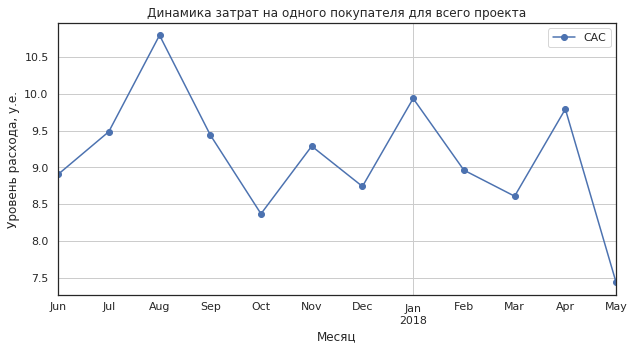

In [187]:
#Выводим график САС на экран
ax = cac.plot(
    x='first_order_month', 
    y='CAC', 
    grid=True, 
    figsize=(10, 5),
    style ='-o',
    title = 'Динамика затрат на одного покупателя для всего проекта')

#Подписываем оси
ax.set_ylabel('Уровень расхода, у.е.')
ax.set_xlabel('Месяц');

Стоимость привлечения одного клиента на проект в августе была самой высокой - **10,8**, самая низкая - в октябре. В осенне-зимнее месяцы стоимость привлечения не такая высокая, "пиковые" расходы на клиента приходятся на август, январь и апрель.

Рассчитаем САС по источникам привлечения пользователя.

In [188]:
#Добавляем первый источник пользователя из таблицы sources
orders_CAC = pd.merge(sources, on = 'uid', right = orders)

In [189]:
#Выводим первые пять строк таблицы
orders_CAC.head()

,uid,source_id,buy_ts,revenue,first_orders_ts
0,313578113262317,2,2018-01-01,0.550000,2018-01-01
1,1575281904278712,10,2017-06-01,1.220000,2017-06-01
2,1575281904278712,10,2017-06-01,1.830000,2017-06-01
3,2429014661409475,3,2017-10-01,73.330002,2017-10-01
4,2464366381792757,5,2018-01-01,2.440000,2018-01-01


In [190]:
#Считаем размер когорт по месяцу первой покупки и источнику
cohort_sizes_CAC = orders_CAC.groupby(['first_orders_ts', 'source_id']).agg({'uid': 'nunique'}).reset_index()

In [191]:
#Переименовываем столбец
cohort_sizes_CAC = cohort_sizes_CAC.rename(columns={'first_orders_ts':'month'})

In [192]:
#Группируем затраты по источникам и месяцам
cost_CAC = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()
cost_CAC.head()

,month,source_id,costs
0,2017-06-01,1,1125.609985
1,2017-06-01,2,2427.379883
2,2017-06-01,3,7731.649902
3,2017-06-01,4,3514.800049
4,2017-06-01,5,2616.120117


In [193]:
#Добавляем первый источник пользователя из таблицы sources
cohort_sizes_CAC = pd.merge(cost_CAC, on = ('source_id', 'month'), right = cohort_sizes_CAC)

In [194]:
#Выводим первые пять строк таблицы
cohort_sizes_CAC.head()

,month,source_id,costs,uid
0,2017-06-01,1,1125.609985,190
1,2017-06-01,2,2427.379883,235
2,2017-06-01,3,7731.649902,638
3,2017-06-01,4,3514.800049,413
4,2017-06-01,5,2616.120117,384


In [195]:
#Считаем САС
cohort_sizes_CAC['buy_cost'] = cohort_sizes_CAC['costs'] / cohort_sizes_CAC['uid']

In [196]:
#Выводим первые пять строк таблицы
cohort_sizes_CAC.head()

,month,source_id,costs,uid,buy_cost
0,2017-06-01,1,1125.609985,190,5.924263
1,2017-06-01,2,2427.379883,235,10.329276
2,2017-06-01,3,7731.649902,638,12.118574
3,2017-06-01,4,3514.800049,413,8.510412
4,2017-06-01,5,2616.120117,384,6.812813


In [197]:
# считаем средний САС по источникам
cohort_sizes_CAC.groupby('source_id')['buy_cost'].mean()

source_id
1      7.212107
2     12.504068
3     13.802743
4      6.439374
5      7.451938
9      5.413892
10     4.867125
Name: buy_cost, dtype: float64

In [198]:
#Формируем сводную таблицу
result_CAC = cohort_sizes_CAC.pivot_table(
        index='source_id', 
        columns='month', 
        values='buy_cost', 
        aggfunc='mean')
result_CAC.loc['mean'] = result_CAC.mean()

In [199]:
#Выводим сводную таблицу на экран
result_CAC

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,5.924263,6.705500,8.423097,6.616784,6.811029,7.546790,7.073112,9.185630,8.016291,6.736975,7.416145,6.089668
2,10.329276,11.216876,14.723984,13.509773,12.234848,13.185126,12.855118,14.238836,15.270784,11.700712,14.255714,6.527767
3,12.118574,14.989004,18.230089,12.757426,13.660799,14.001102,12.315505,14.720458,13.029816,13.640093,15.019080,11.150971
4,8.510412,6.827331,9.518817,8.800441,5.478532,4.578437,5.577684,5.651928,5.164521,5.515143,6.407689,5.241555
5,6.812813,7.087801,6.070222,6.535042,6.103069,9.127475,7.616757,8.485814,7.479808,8.578826,8.142209,7.383421
9,4.194412,5.818077,4.080820,4.777241,4.836587,4.711586,5.437851,6.839500,6.565476,2.983168,8.685814,6.036167
10,3.307579,6.467059,6.285676,5.356628,3.001148,6.190312,7.598353,6.677718,3.909594,2.830161,3.628505,3.152769
mean,7.313904,8.444521,9.618958,8.336191,7.446573,8.477261,8.353483,9.399983,8.490899,7.426440,9.079308,6.511760


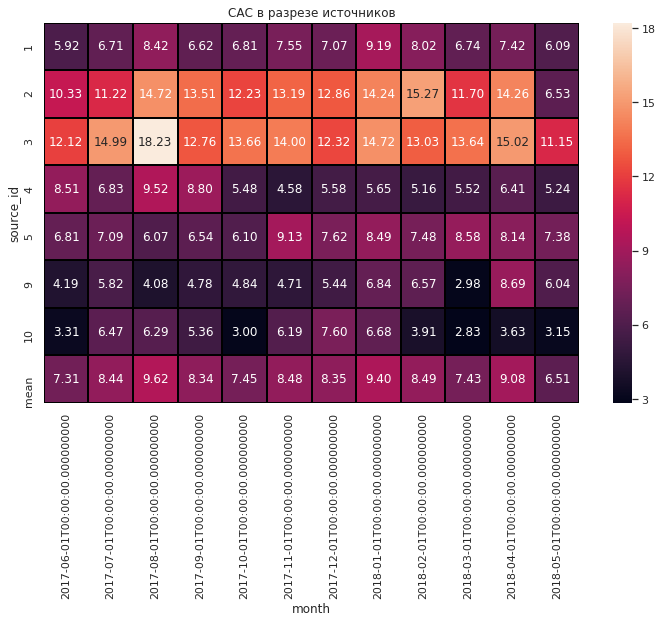

In [200]:
# Строим тепловую карту среднего CAC источников
plt.figure(figsize=(12, 7))
plt.title('CAC в разрезе источников')
sns.heatmap(result_CAC.round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black') 

Опишем средний CAC для каждого источника трафика:

Источник **1** - CАС - 7.21

Источник **2** - CАС - 12.5

Источник **3** - CАС - 13.8, самый дорогой источник

Источник **4** - CАС - 6.44.

Источник **5** - CАС - 7.45

Источник **9** - CАС - 5.41 

Источник **10** - CАС - 4.86, самый маленький по расходной части источник

В среднем, самый дорогие месяцы для компании по привлечению клиентов - *август 2017* и *январь 2018*

Самые затратные рекламные источники *3*, *2* и *1*.

<a class="anchor" id="section_2_3_3"></a>
##### ROMI по когортам в разрезе источников 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

In [214]:
#Выводим первые пять строк таблицы
orders.head()

,buy_ts,revenue,uid,first_orders_ts
0,2017-06-01,17.00,10329302124590727494,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01
2,2017-06-01,0.37,17903680561304213844,2017-06-01
3,2017-06-01,0.55,16109239769442553005,2017-06-01
4,2017-06-01,0.37,14200605875248379450,2017-06-01


In [215]:
#Добавляем первый источник пользователя из таблицы sources
orders = pd.merge(sources, on = 'uid', right = orders)

In [216]:
#Считаем размер когорт по месяцу первой покупки и источнику
cohort_sizes = orders.groupby(['first_orders_ts', 'source_id']).agg({'uid': 'nunique'}).reset_index()

In [217]:
#Переименовываем столбец
cohort_sizes = cohort_sizes.rename(columns={'first_orders_ts':'month'})

In [218]:
#Группируем затраты по источникам и месяцам
costs_grouped_month_source = costs.groupby(['month', 'source_id']).agg({'costs': 'sum'}).reset_index()
costs_grouped_month_source.head()

,month,source_id,costs
0,2017-06-01,1,1125.609985
1,2017-06-01,2,2427.379883
2,2017-06-01,3,7731.649902
3,2017-06-01,4,3514.800049
4,2017-06-01,5,2616.120117


In [219]:
#Добавляем первый источник пользователя из таблицы sources
cohort_sizes = pd.merge(costs_grouped_month_source, on = ('source_id', 'month'), right = cohort_sizes)

In [220]:
#Группируем данные по первому источнику, месяцам покупки
cohorts = orders.groupby(['first_orders_ts', 'buy_ts', 'source_id']).agg({'revenue': 'sum'}).reset_index()

In [221]:
#Переименовываем столбец
cohorts = cohorts.rename(columns={'first_orders_ts':'month'})

In [222]:
# Объединяем две таблицы cohort_sizes и cohorts
report = pd.merge(cohort_sizes, cohorts, on=('month', 'source_id'))

In [223]:
# Вычисляем метрики
report['lifetime'] = (report['buy_ts'] - report['month']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
report['ltv'] = report['revenue'] / report['uid']
report['CAC'] = report['costs'] / report['uid']
report['romi'] = report['ltv'] / report['CAC']

In [224]:
#Формируем сводную таблицу
result = report.pivot_table(
        index='source_id', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean')

#Добавляем среднее значение метрики когорт
result.loc['mean'] = result.mean()

In [225]:
# Выводим отчет на экран
result.cumsum(axis=1).round(2).fillna('') 

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.89,1.05,1.22,1.38,1.51,1.60,1.70,1.89,2.10,2.28,2.45,2.73
2,0.55,0.68,0.80,0.95,1.03,1.10,1.17,1.23,1.27,1.30,1.39,1.43
3,0.34,0.36,0.37,0.38,0.39,0.40,0.40,0.41,0.41,0.42,0.42,0.42
4,0.76,0.79,0.81,0.84,0.87,0.91,0.98,0.99,1.01,1.05,1.12,1.13
5,0.66,0.71,0.75,1.06,1.12,1.19,1.23,1.27,1.31,1.37,1.38,1.4
9,0.77,0.83,0.91,0.98,1.03,1.07,1.13,1.18,1.28,1.31,1.32,
10,0.73,0.75,0.76,0.78,0.79,0.80,0.81,0.82,0.82,0.84,,
mean,0.67,0.74,0.80,0.91,0.96,1.01,1.06,1.11,1.17,1.22,1.28,1.35


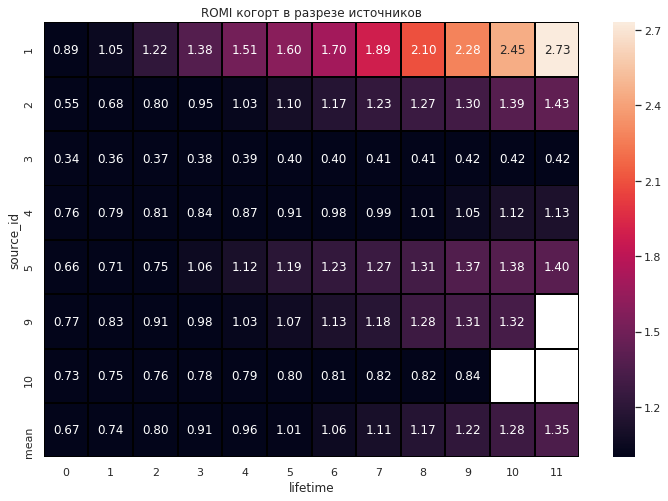

In [226]:
# Строим тепловую карту romi когорт
plt.figure(figsize=(12, 8))
plt.title('ROMI когорт в разрезе источников')
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='black', vmin = 1) 

Опишем окупаемость источников рекламного трафика:

Источник **1** - окупаемость наступает на второй месяц, наблюдается положительная динамика когорт.

Источник **2** - окупается за 5 месяцев, показатель растет на протяжении остальных месяцев.

Источник **3** - не окупился, динамика с 6-го месяца жизни почти отсутствует.

Источник **4** - окупился на 9-м месяце жизни, небольшая динамика, покупки совершаются редко.

Источник **5** - окупился на 4-м месяце, низкая динамика

Источник **9** - окупился на 5-й месяц, низкая динамика

Источник **10** - не окупился за 10 месяцев

В среднем, в совокупности источники сработали положительно. Совокупно рекламные источники смогли достичь окупаемости на 6-й месяц.

<a class="anchor" id="chapter3"></a>
### Рекомендации 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

<a class="anchor" id="section_3_1"></a>
#### Источники трафика и тип устройств, на которые маркетологам стоит делать упор 
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Анализ показал, что большинство клиентов на устройстве **desktop**, однако считаю нужным развивать интуитивно понятный и удобный интерфейс для устройства **touch**, так как он более мобильный. Пользователь сможет в любой момент воспользоваться сервисом, удобный интерфейс поможет пользователю проникнуться сервисом и охотнее совершить покупку.

С утройства *desktop* заходы осуществляются чаще, чем на с утройства *touch*.

Самые привлекательные рекламные источники для компании - **1** и **2** - привлекают клиентов, которые регулярно совершают покупки, клиентов привлекли не так много, но зато "качественно" лучше.

Источник **3** и источник **4** привлекают больше клиентов, чем остальные источники. Однако, источник **4** в расходной части оказался более выгоден, но с точки зрения качества клиентов не такой привлекательный. Клиенты источника **4** совершают покупку, затем редко возвращаются в сервис снова.

Что касается *САС*: самый затратный рекламные источники - **2** и **3**.

Возможно, компании стоит сделать упор на привлечение большего количества клиентов из источников **1**, **2** и **5**, данные источники окупаются и приносят клиентов, которые совершают регулярные покупки.

<a class="anchor" id="section_3_2"></a>
#### Самые перспективные для компании когорты клиентов
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Из проведенного анализа можно предположить, что в сервисе присутствует сезонность. Когорты ****сентября**** и ****декабря**** совершают покупки охотнее, чем когорты *июня* и *октября*.

<a class="anchor" id="section_3_3"></a>
#### Различие метрик в разрезе устройств
<a class="anchor" href="#1">Вернуться к оглавлению</a>

Пользователи с устройства *desktop* проводят больше времени в сервисе, чем пользователи на *touch*.
Так, в среднем, пользователи на *desktop* находятся в сервисе - **774 секунды** (почти 13 минут), а пользователи на *touch* - **548 секунд** (9 минут).

Пользователи устройства *desktop* были наиболее активны в *ноябре*, в последующие месяцы активность плавно уменьшалась. 

Пользователи на устройстве типа *touch* были почти одинаково активны с *октября* по *март 2018*.

Когорты *desktop* больше, чем когорты устройства *touch*.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  файлы загружены
- [x]  данные о визитах, заказах и расходах сохранены в переменные
- [x]  данные для анализа оптимизированы
- [x]  данные приведены к нужному типу данных
- [x]  дан ответ на вопрос: "Сколько людей пользуются в день, неделю, месяц?"
- [x]  дан ответ на вопрос: "Сколько сессий в день?"
- [x]  дан ответ на вопрос: "Сколько длится одна сессия?"
- [x]  дан ответ на вопрос: "Как часто люди возвращаются?"
- [x]  дан ответ на вопрос: "Когда люди начинают покупать?"
- [x]  дан ответ на вопрос: "Сколько раз покупают за период?"
- [x]  дан ответ на вопрос: "Какой средний чек?"
- [x]  дан ответ на вопрос: "Сколько денег приносят? (LTV)"
- [x]  дан ответ на вопрос: "Сколько денег потратили?"
- [x]  дан ответ на вопрос: "Сколько стоило привлечение одного покупателя из каждого источника?"
- [x]  дан ответ на вопрос: "На сколько окупились расходы? (ROI)"
- [x]  сделаны выводы к каждому графику
- [x]  в каждом этапе есть выводы